# Генератор отзывов

## Импорт библиотек

In [65]:
import os
import re
from collections import Counter
from functools import reduce
from operator import add
import wget
import random
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

## EDA

### Загрузка датасета

In [ ]:
url = 'https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv'
filename = wget.download(url)

### Преобразование в датафрейм

In [2]:
# Считаем при помощи pandas исходный файл с табуляцией в качестве разделителя, задав нужные нам имена колонок
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# Пройдем в цикле по колонкам и удалим из ячеек ключи
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [24]:
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


### Базовый анализ датафрейма

Посмотрим основную информацию по нашему датафрейму

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


Видим, что в колонке 'text' есть пропущенные значения. Поскольку данных у нас очень много, и целиком датасет мы все равно использовать не будем (так как дообучение моделей тогда растянется на несколько недель), просто удалим все строки, где есть пропущенные значения.

In [3]:
df = df.dropna(ignore_index=True)

In [ ]:
# Теперь обрежем точку после цифры в колонке 'rating' и приведем колонку к типу int64
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

In [ ]:
# Сохраним наш датафрейм в tsv файл для дальнейшей работы
df.to_csv('geo-reviews-dataset-2023.tsv', sep='\t', index=False)

Посмотрим, как в датасете распределены оценки

<Axes: xlabel='rating', ylabel='Count'>

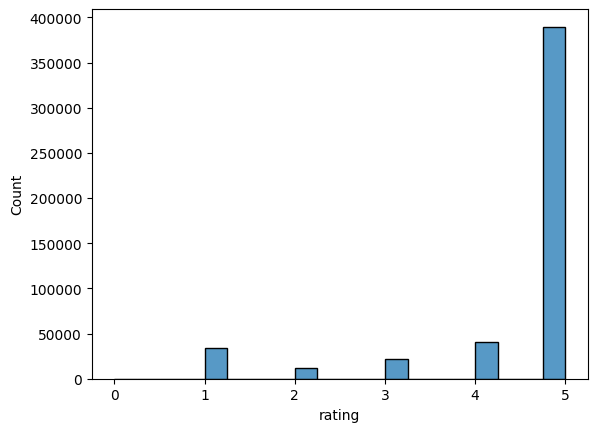

In [5]:
sns.histplot(df['rating'])

Как мы видим, отзывы на 5 звезд люди оставляют значительно чаще, чем с другим рейтингом. Наверное, в дальнейшем нам стоит сбалансировать классы для обучающей выборки.

Добавим в наш датафрейм колонку, в которой будет указана длина отзыва и проанализируем полученный результат.

In [5]:
df['review_length'] = df['text'].str.len()

In [6]:
df['review_length'].describe()

count    499030.000000
mean        303.232533
std         292.609661
min           2.000000
25%         145.000000
50%         215.000000
75%         365.000000
max       20162.000000
Name: review_length, dtype: float64

<Axes: xlabel='review_length', ylabel='Count'>

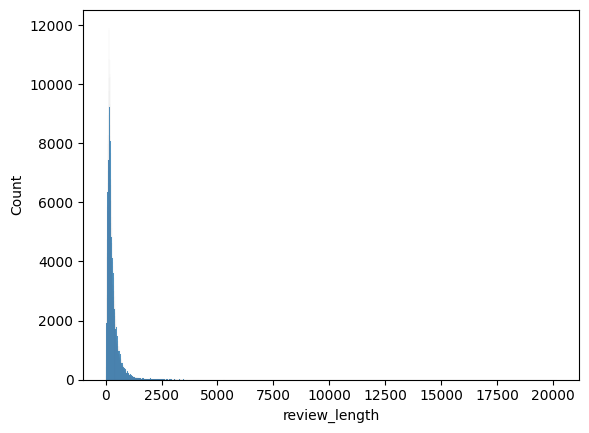

In [52]:
sns.histplot(df['review_length'])

<Axes: ylabel='review_length'>

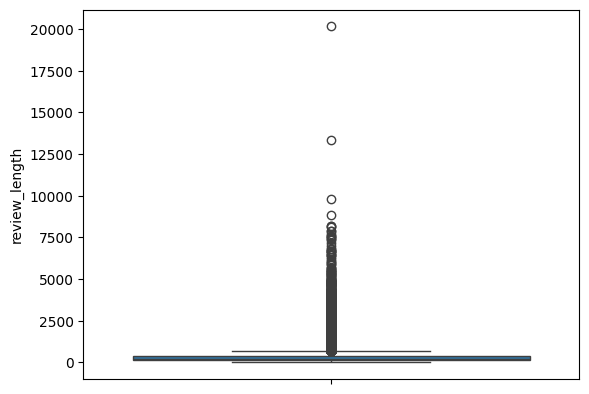

In [53]:
sns.boxplot(df['review_length'])

Как видим, у нас присутствуют выбросы (как подозрительно маленькая длина отзыва, так и слишком большая). В дальнейшем нужно будет удалить выбросы из датафрейма. 

### Расчет частотности слов

Теперь посчитаем количество уникальных слов в отзывах

In [ ]:
# Соберем все тексты отзывов в одну строку
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

In [38]:
# Удалим из строки все спец.символы
def remove_chars_from_text(text, chars):
    return "".join([char for char in text if char not in chars])

spec_chars = string.punctuation + '\n\xa0«»\t—…n'

text = remove_chars_from_text(words_str, spec_chars)
text = remove_chars_from_text(text, string.digits)

# Приведем все слова к нижнему регистру
text = text.lower()

In [40]:
# Токенизируем текст
nltk.download('punkt_tab')
text_tokens = word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [46]:
# Посмотрим статистику по неочищенным словам


# Для применения инструментов частотного анализа библиотеки NLTK необходимо список токенов преобразовать к классу Text
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

print('Статистика по неочищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по неочищенным словам

Всего слов: 21306636

Уникальных слов: 742932

Топ-10 слов по частоте: 
и:  874480
в:  604858
не:  400240
на:  389339
очень:  298972
с:  289708
что:  205890
все:  170685
но:  141965
по:  137147


In [59]:
# Теперь очистим слова от служебных частей речи
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['очень', 'это', 'всё', 'всем', 'еще', 'ещё']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
# И посмотрим статистику по очищенным словам

fdist = FreqDist(text_with_no_stopwords)

print('Статистика по очищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по очищенным словам

Всего слов: 14173971

Уникальных слов: 742776

Топ-10 слов по частоте: 
персонал:  82456
место:  74975
спасибо:  73776
рекомендую:  60037
просто:  49583
магазин:  46361
хороший:  43166
цены:  42268
вкусно:  40279
быстро:  40030


<Axes: xlabel='Samples', ylabel='Counts'>

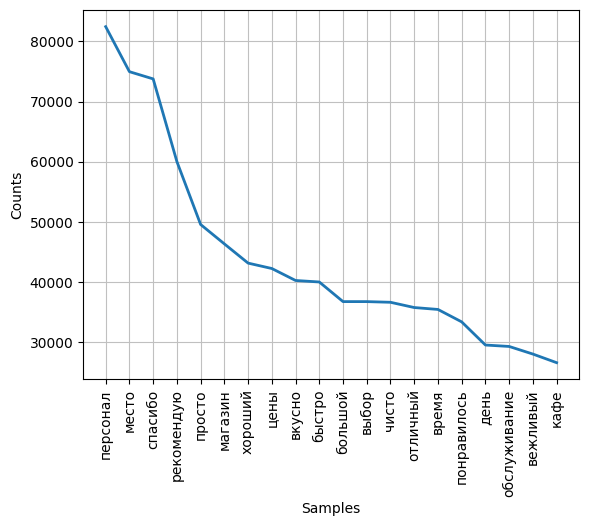

In [62]:
# Чтобы добавить сюда что-нибудь красивое - нарисуем график частоты топ-20 очищенных слов

fdist.plot(20,cumulative=False)

### Составим облако слов

In [77]:
# Для построения облака слов на вход методу необходимо передать строку
text_raw = " ".join(text_with_no_stopwords)
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

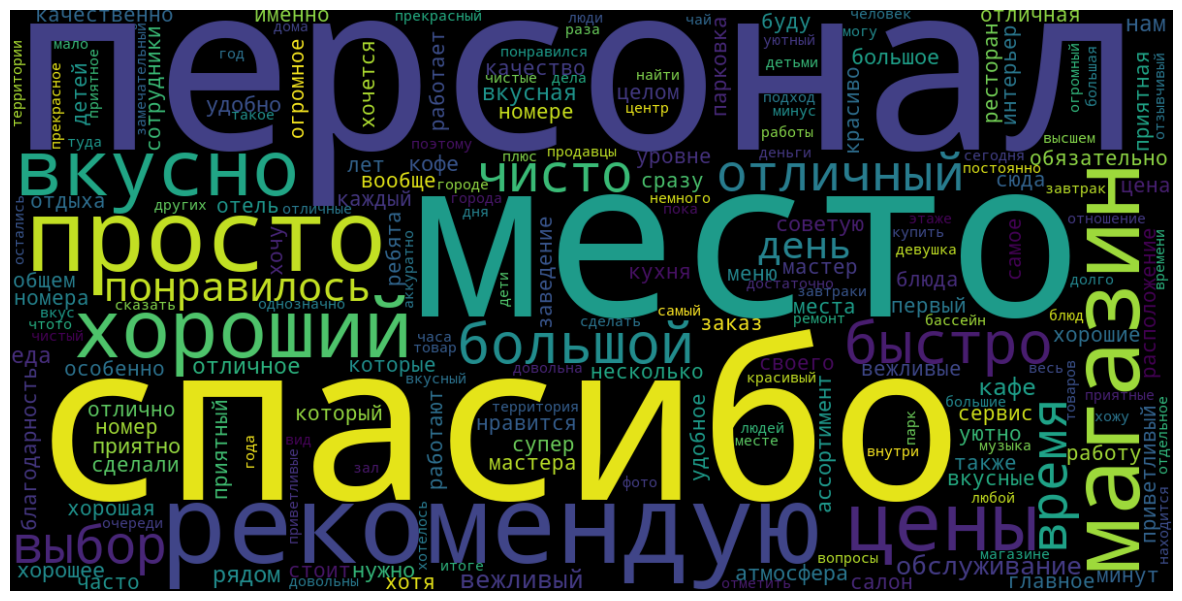

In [78]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Предобработка

## Обучение

## Совершенствование

## Анализ

## Итог

In [ ]:
print('try me my mad')